# Models analysis

# Load test data and models to compare

In [ ]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import preprocess_data as ppd


# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif



from typing import Iterable
from pathlib import Path



importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

## Load data

In [5]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [6]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']




test_data = {}
train_data = {}

for initial_state in ['A', 'D', 'U']:
    print(f"\nProcessing initial MC state: {initial_state}")
    # ---------- Merge + label prep ----------
    train_df, test_df, feature_names, target_columns, integer_encoding = dp.preprocess_data(failure_data_path=failure_data_file,
                                                                                weather_data_path=weather_data_file,
                                                                                power_load_data_path=power_load_file,
                                                                                feature_names=feature_names_base,
                                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                state_one_hot=True,
                                                                                initial_MC_state_filter=initial_state,
                                                                                technology_filter=technologies,
                                                                                test_periods=test_periods
                                                                                )
    test_data[initial_state] = test_df
    train_data[initial_state] = train_df

# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

print(f"Encoding for 'Final_gen_state': {integer_encoding['Final_gen_state']}")

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']

Processing initial MC state: A

Processing initial MC state: D

Processing initial MC state: U
Standardized features (14): ['24h_max_load', 'HDD3d', 'Tmax', '2d_load_sum', 'FDD3d', 'Load', 'Tmin', '24h_min_load', 'CDD', 'HDD', 'CDD3d', '1d_load_sum', 'Tmean', 'FDD']
Encoding for 'Final_gen_state': {'A': 0, 'D': 1, 'U': 2}


In [ ]:
def clean_state_name(state_col: str) -> str:
    s = state_col.split('_')[1]
    clean_s = ''
    for w in s.split( ' '):
        clean_s += w.capitalize() + ' '
    state = clean_s.strip()
    return state

## Load models

In [114]:
models = defaultdict(lambda: defaultdict(dict))

# ---------- Load models ----------
for state in ['Global' ,'California', 'Texas', 'New York', 'Connecticut']:
    for initial_state in ['A', 'D', 'U']:
        if state != 'Global':
            state_mk = '_' + state
        else:
            state_mk = ''
        
        # -- MLP --
        # try:
        mlp_loader = im.MLP(verbose=False)
        mlp_model = mlp_loader.load_model(f"../Results/Models/MLP_model{state_mk}_{techno}_{initial_state}.pth")
        models[state][initial_state]['mlp'] = mlp_model
        # except Exception as e:
        #     print(f"Could not load MLP model for state {state} and initial state {initial_state}: {e}")
        #     pass

        # -- XGBoost --
        # try:
        xgb_loader = im.xgboostModel(verbose=False)
        xgb_model = xgb_loader.load_model(f"../Results/Models/XGB_model{state_mk}_{techno}_{initial_state}.pth")
        models[state][initial_state]['xgb'] = xgb_model
        # except Exception as e:
        #     print(f"Could not load XGB model for state {state} and initial state {initial_state}: {e}")
        #     pass

Sequential(
  (linear_0): Linear(in_features=90, out_features=256, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=256, out_features=512, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=256, out_features=128, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=128, out_features=64, bias=True)
  (activation_4): ReLU()
  (linear_out): Linear(in_features=64, out_features=3, bias=True)
)
Input dim: 90 | Output dim: 3 | Trainable params: 327,555
Loaded MLP from ../Results/Models/MLP_model_thermal_A.pth
Rebuilt with build_model(**['feature_cols', 'target_cols', 'num_classes', 'hidden_sizes', 'activations', 'out_act_fn'])
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=10,
              enable_categ

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Ideal and simplest model

In [6]:
def CE_min(df, features):
    """Returns the probabilities that minimize the cross entropy on the test set (for comparison with model predictions)"""
    df_counts = df[features+['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts =  df_counts.groupby(features).sum('count')
    res = df.join(counts, on=features,  how='left')
    res["probability_CE_min"] = res['Data_weight'] / res['count']

    p0 = res.loc[res['Final_gen_state']==0]
    p1 = res.loc[res['Final_gen_state']==1]
    p2 = res.loc[res['Final_gen_state']==2]

    p0 = p0.groupby(['Datetime_UTC']+features).sum()
    p1 = p1.groupby(['Datetime_UTC']+features).sum()
    p2 = p2.groupby(['Datetime_UTC']+features).sum()

    p0 = p0['probability_CE_min']
    p1 = p1['probability_CE_min']
    p2 = p2['probability_CE_min']

    res = res.join(p0, on=['Datetime_UTC']+features, how='left', rsuffix='_0')
    res = res.join(p1, on=['Datetime_UTC']+features, how='left', rsuffix='_1')
    res = res.join(p2, on=['Datetime_UTC']+features, how='left', rsuffix='_2')

    res.fillna(0, inplace=True)

    probs = res[['probability_CE_min_0', 'probability_CE_min_1', 'probability_CE_min_2']].to_numpy()

    return probs

In [7]:
def freq_model(df_train, features, target_cols):
    """Returns the frequency-based model probability on the test set (for comparison with model predictions).
    We compute historical frequency of transition for each state and technology, and use it as a model. It is agnostic to any other features."""
    states = [f for f in df_train.columns if f.startswith("State_")]
    techs = [f for f in df_train.columns if f.startswith("Technology_")]

    if not states and not techs:
        freq = df_train.groupby(target_cols).sum('Data_weight')
        total = freq['Data_weight'].sum()

        prob_dict = {}
        gen_states = freq.index.unique()
        prob_dict = [ (freq.loc[init_state]['Data_weight'] / total) for init_state in gen_states]
        def p(input_df):
            if isinstance(input_df, pd.DataFrame):
                out = np.array([prob_dict for _ in range(len(input_df))])
                return out
            else:
                return np.array(prob_dict)
        return p

    df_counts = df_train[states + techs + target_cols + ['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts = df_counts.groupby(states + techs + target_cols).sum('count').reset_index()
    counts_total = counts.groupby(states + techs).sum('count')
    counts = counts.join(counts_total, how='left', on=states + techs, rsuffix='_total')
    counts['prob'] = counts['count'] / counts['count_total']

    for s in states:
        counts.rename(columns={s: clean_state_name(s)}, inplace=True)
    states_clean = [clean_state_name(s) for s in states]


    prob_dict = {}
    gen_states = counts[target_cols[0]].unique()
    for s in states_clean:
        prob_dict[s] = {}
        if techs:
            for t in techs:
                mask = (counts[s]==1)&(counts[t]==1)
                sub_counts = counts.loc[mask]
                if not sub_counts.empty:
                    prob_dict[s][t] = []
                    for init_state in gen_states:
                        mask2 = sub_counts[target_cols[0]] == init_state
                        if not sub_counts.loc[mask2].empty:
                            prob = sub_counts.loc[mask2]['prob'].values[0]
                        else:
                            prob = 0.0
                        prob_dict[s][t].append(prob)
                else:
                    prob_dict[s][t] = [0.0 for _ in gen_states]
        else:
            mask = (counts[s]==1)
            sub_counts = counts.loc[mask]
            if not sub_counts.empty:
                prob_dict[s] = []
                for init_state in gen_states:
                    mask2 = sub_counts[target_cols[0]] == init_state
                    if not sub_counts.loc[mask2].empty:
                        prob = sub_counts.loc[mask2]['prob'].values[0]
                    else:
                        prob = 0.0
                    prob_dict[s].append(prob)
            else:
                prob_dict[s] = [0.0 for _ in gen_states]


    def p(input_df):
        # vectorized prediction for DataFrame input
        if isinstance(input_df, pd.DataFrame):
            # get winning state and technology column names per row
            state_cols = input_df[states]
            tech_cols = input_df[techs]

            state_idx = state_cols.idxmax(axis=1)  # e.g. "State_NORTH DAKOTA"
            if not tech_cols.empty:
                tech_idx = tech_cols.idxmax(axis=1)    # e.g. "Technology_CC GT units"

            # clean state names to match keys in prob_dict (capitalise words)
            states_clean = state_idx.str.replace("State_", "", regex=False).str.title()

            # build a mapping (state_clean, tech_col) -> probability array
            pair_to_probs = {}
            if not tech_cols.empty:
                for s, techs_dict in prob_dict.items():
                    for t, arr in techs_dict.items():
                        pair_to_probs[(s, t)] = np.asarray(arr)
            else:
                for s, arr in prob_dict.items():
                    pair_to_probs[(s)] = np.asarray(arr)
            # for s, techs_dict in prob_dict.items():
            #     for t, arr in techs_dict.items():
            #         pair_to_probs[(s, t)] = np.asarray(arr)

            # determine number of classes (use any entry) and default vector
            if pair_to_probs:
                sample_vec = next(iter(pair_to_probs.values()))
                n_classes = sample_vec.shape[0]
                default_vec = np.zeros(n_classes, dtype=sample_vec.dtype)
            else:
                return np.empty((len(input_df), 0))

            # build MultiIndex DataFrame for fast reindexing
            tuples = list(pair_to_probs.keys())
            probs_matrix = np.vstack(list(pair_to_probs.values()))
            if techs:
                probs_df = pd.DataFrame(probs_matrix, index=pd.MultiIndex.from_tuples(tuples, names=("state","tech")))
            else:
                probs_df = pd.DataFrame(probs_matrix, index=pd.Index(tuples, name="state"))

            # create index of requested pairs and reindex (fills missing with NaN -> replace with zeros)
            if techs:
                requested_pairs = list(zip(states_clean.values, tech_idx.values))
            else:
                requested_pairs = list(states_clean.values)
            out = probs_df.reindex(requested_pairs).fillna(0).values

            return out

        # scalar (single row / Series) input
        else:
            state = clean_state_name(input_df[states].idxmax())
            if techs:
                tech = input_df[techs].idxmax()
                return np.array(prob_dict.get(state, {}).get(tech, []))
            else:
                return np.array(prob_dict.get(state, {}))


    return p

# Scoring

## Transition probability scores (CE)

In [8]:
def cross_entropy(probs: np.ndarray, true_labels: np.ndarray, weights: np.ndarray) -> float:
    """
    Compute the cross-entropy loss given predicted probabilities and true labels.

    Parameters:
    probs (np.ndarray): Predicted probabilities for each class (shape: [n_samples, n_classes]).
    true_labels (np.ndarray): True class labels (shape: [n_samples]).
    weights (np.ndarray): Sample weights (shape: [n_samples]).

    Returns:
    float: Cross-entropy loss.
    """
    n_samples = true_labels.shape[0]
    # Clip probabilities to avoid log(0)
    clipped_probs = np.clip(probs, 1e-15, 1 - 1e-15)
    # Get the probabilities corresponding to the true labels
    true_class_probs = clipped_probs[np.arange(n_samples), true_labels]
    # Compute cross-entropy
    ce_loss = -np.sum(np.log(true_class_probs) * weights) / np.sum(weights)
    return ce_loss


### Global

In [31]:
scores = {"Model":[], "State":[], "Initial_State":[], "Cross_Entropy":[]}

for state in ['California', 'Texas', 'New York', 'Connecticut']:
    print(f"\nEvaluating models for state: {state}")
    for initial_state in ['A', 'D', 'U']:
            train_df = train_data[initial_state]
            test_df = test_data[initial_state]
            if state != 'Global':
                  train_df = train_df.loc[train_df['State_'+state.upper()]==1].copy()
                  test_df = test_df.loc[test_df['State_'+state.upper()]==1].copy()
            y_true = test_df['Final_gen_state'].values
            sample_weights = test_df['Data_weight'].values
            feature_state = [f for f in feature_names if f in train_df.columns]

            # Frequency model
            freq_p = freq_model(train_df, feature_state, ['Final_gen_state'])
            probs_freq = freq_p(test_df[feature_state])
            ce_freq = cross_entropy(probs_freq, y_true, sample_weights)
            # scores[initial_state]['freq'] = ce_freq
            scores['Model'].append('Frequency')
            scores['State'].append(state)
            scores['Initial_State'].append(initial_state)
            scores['Cross_Entropy'].append(ce_freq)


            # CE minimum
            p_ce_min = CE_min(test_df, feature_state)
            ce_min = cross_entropy(p_ce_min, y_true, sample_weights)
            scores['Model'].append('CE_minimum')
            scores['State'].append(state)
            scores['Initial_State'].append(initial_state)
            scores['Cross_Entropy'].append(ce_min)


            # XGB
            xgb_model = models[state][initial_state]['xgb']
            probs_xgb = xgb_model.predict(test_df[feature_state])
            ce_xgb = cross_entropy(probs_xgb, y_true, sample_weights)
            scores['Model'].append('XGBoost')
            scores['State'].append(state)
            scores['Initial_State'].append(initial_state)
            scores['Cross_Entropy'].append(ce_xgb)

            # XGB global
            xgb_global_model = models['Global'][initial_state]['xgb']
            probs_xgb_global = xgb_global_model.predict(test_df[feature_state])
            ce_xgb_global = cross_entropy(probs_xgb_global, y_true, sample_weights)
            scores['Model'].append('XGBoost_global')
            scores['State'].append(state)
            scores['Initial_State'].append(initial_state)
            scores['Cross_Entropy'].append(ce_xgb_global)

            # MLP
            mlp_model = models[state][initial_state]['mlp']
            probs_mlp = mlp_model.predict(test_df[feature_state])
            ce_mlp = cross_entropy(probs_mlp, y_true, sample_weights)
            scores['Model'].append('MLP')
            scores['State'].append(state)
            scores['Initial_State'].append(initial_state)
            scores['Cross_Entropy'].append(ce_mlp)

            # MLP global
            mlp_global_model = models['Global'][initial_state]['mlp']
            probs_mlp_global = mlp_global_model.predict(test_df[feature_state])
            ce_mlp_global = cross_entropy(probs_mlp_global, y_true, sample_weights)
            scores['Model'].append('MLP_global')
            scores['State'].append(state)
            scores['Initial_State'].append(initial_state)
            scores['Cross_Entropy'].append(ce_mlp_global)



scores = pd.DataFrame(scores)


Evaluating models for state: California

Evaluating models for state: Texas

Evaluating models for state: New York

Evaluating models for state: Connecticut


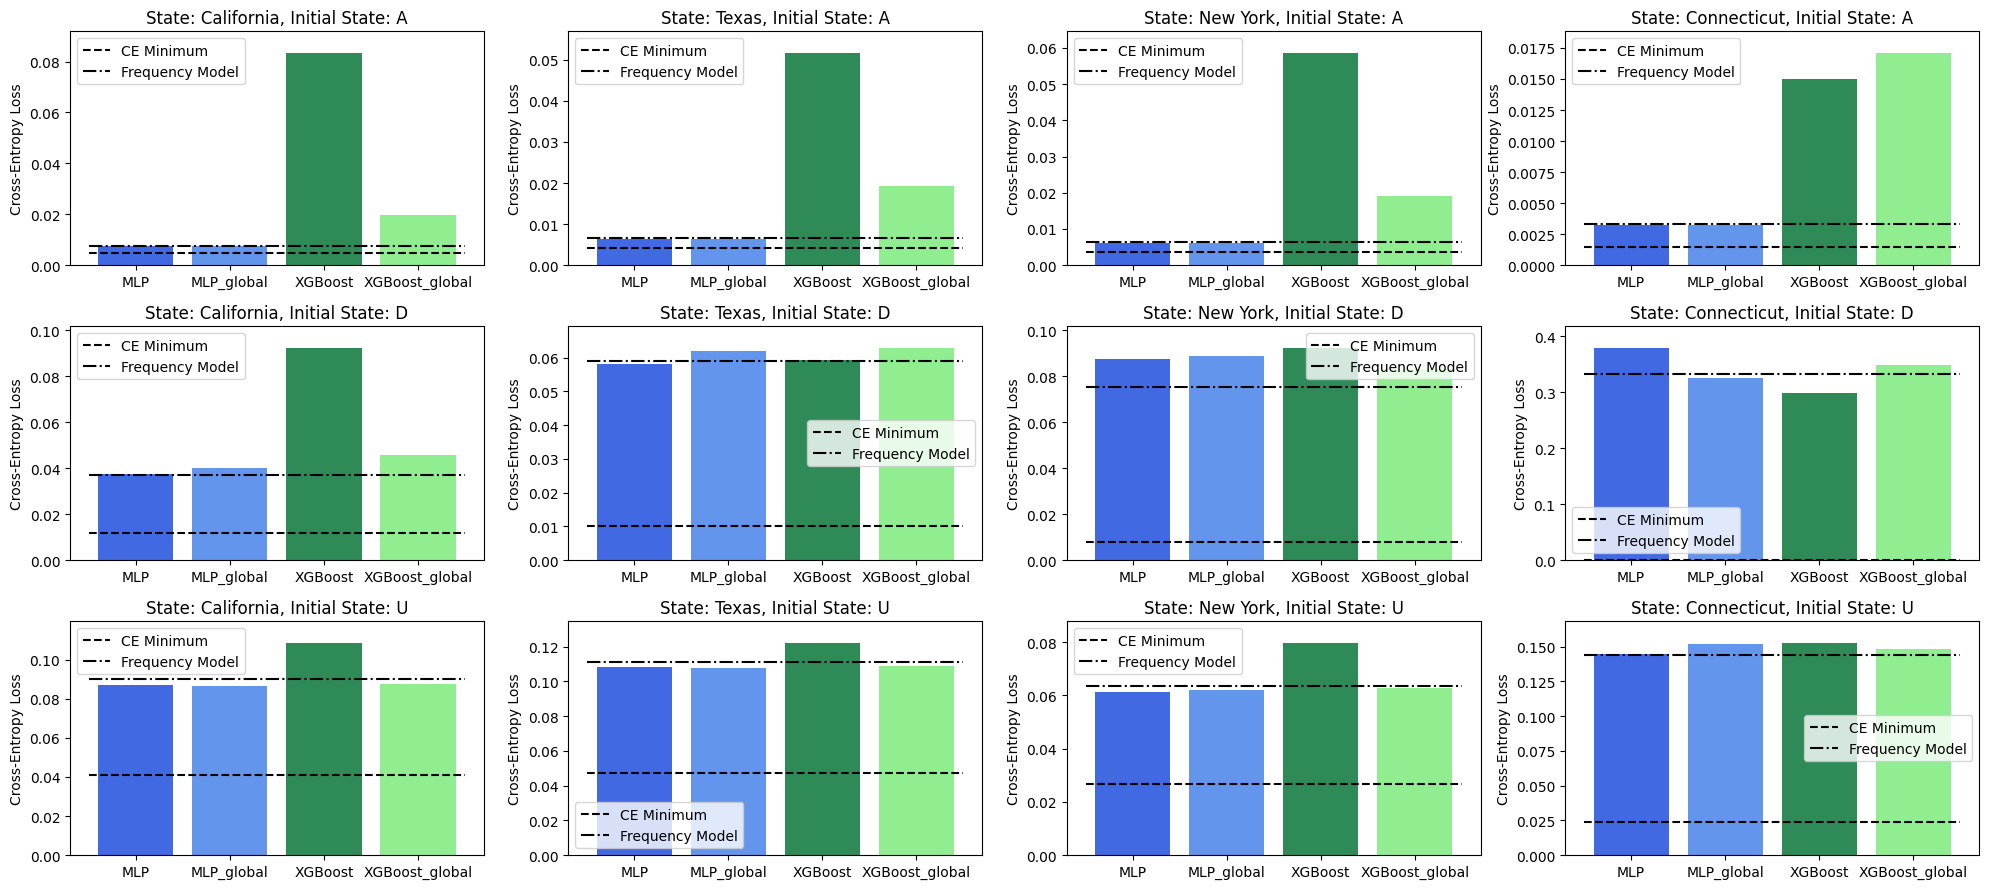

In [42]:
fig, axs = plt.subplots(3, scores['State'].nunique(), figsize=(20, 9))
for i, initial_state in enumerate(['A', 'D', 'U']):
    for j, state in enumerate(scores['State'].unique()):
        state_scores = scores[(scores['State']==state) & (scores['Initial_State']==initial_state)]
        ax = axs[i,j]
        ce_min = state_scores.loc[state_scores['Model']=='CE_minimum', 'Cross_Entropy'].values[0]
        ce_freq = state_scores.loc[state_scores['Model']=='Frequency', 'Cross_Entropy'].values[0]
        ce_models = state_scores[~state_scores['Model'].isin(['CE_minimum', 'Frequency'])]
        ce_models = ce_models.sort_values(by='Model')
        ax.plot([-0.5, len(ce_models)-0.5], [ce_min, ce_min], 'k--', label='CE Minimum')
        ax.plot([-0.5, len(ce_models)-0.5], [ce_freq, ce_freq], 'k-.', label='Frequency Model')
        ax.bar(ce_models['Model'], ce_models['Cross_Entropy'], color=['royalblue', 'cornflowerblue', 'seagreen', 'lightgreen'])
        ax.set_title(f"State: {state}, Initial State: {initial_state}")
        ax.set_ylabel("Cross-Entropy Loss")
        ax.set_ylim(0, max(state_scores['Cross_Entropy']) * 1.1)
        ax.legend()
plt.tight_layout()
plt.show()
        


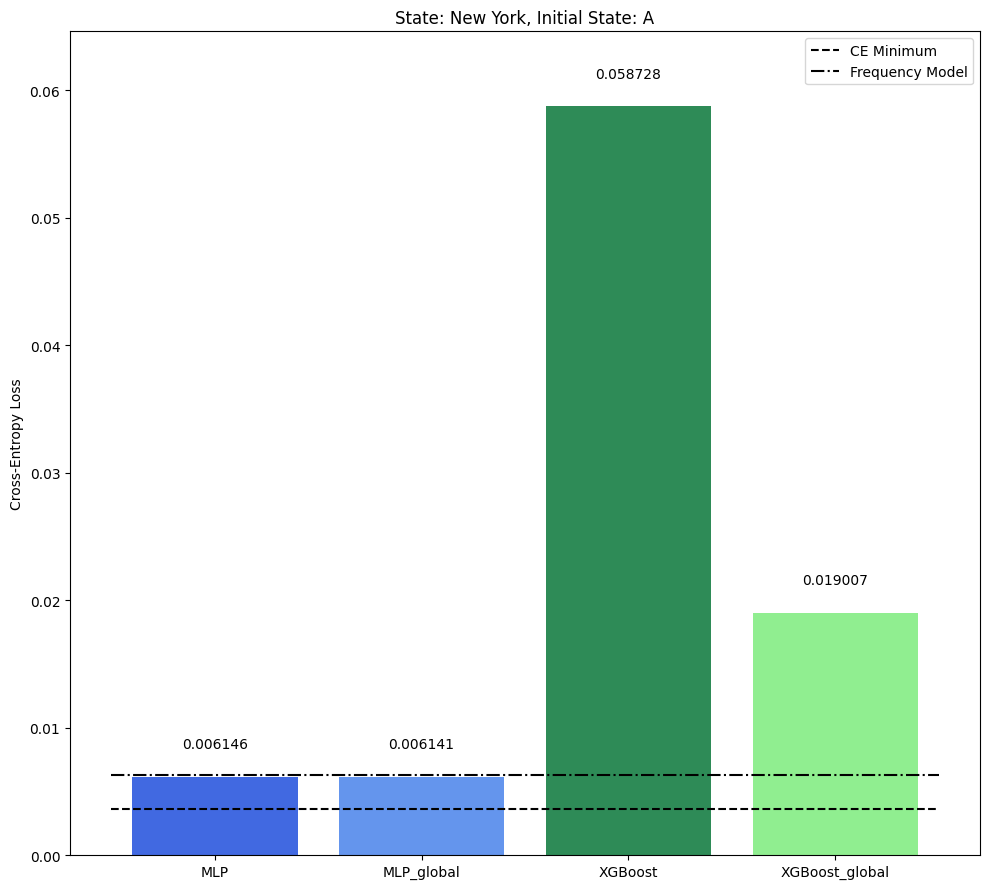

In [48]:
initial_state = 'A'
state = 'New York'

fig, ax = plt.subplots(figsize=(10, 9))
state_scores = scores[(scores['State']==state) & (scores['Initial_State']==initial_state)]
ce_min = state_scores.loc[state_scores['Model']=='CE_minimum', 'Cross_Entropy'].values[0]
ce_freq = state_scores.loc[state_scores['Model']=='Frequency', 'Cross_Entropy'].values[0]
ce_models = state_scores[~state_scores['Model'].isin(['CE_minimum', 'Frequency'])]
ce_models = ce_models.sort_values(by='Model')
ax.plot([-0.5, len(ce_models)-0.5], [ce_min, ce_min], 'k--', label='CE Minimum')
ax.plot([-0.5, len(ce_models)-0.5], [ce_freq, ce_freq], 'k-.', label='Frequency Model')
ax.bar(ce_models['Model'], ce_models['Cross_Entropy'], color=['royalblue', 'cornflowerblue', 'seagreen', 'lightgreen'])
for j, v in enumerate(ce_models['Cross_Entropy']):
    ax.text(j, v + 0.002, f"{v:.6f}", ha='center', va='bottom')

ax.set_title(f"State: {state}, Initial State: {initial_state}")
ax.set_ylabel("Cross-Entropy Loss")
ax.set_ylim(0, max(state_scores['Cross_Entropy']) * 1.1)
ax.legend()
plt.tight_layout()
plt.show()
        


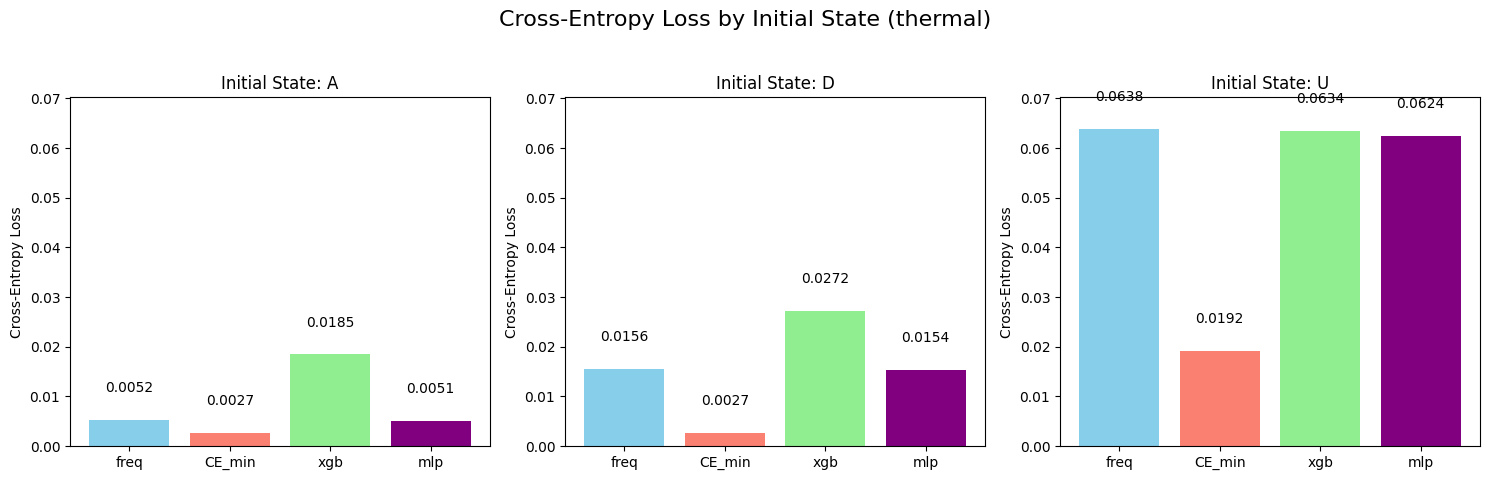

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, initial_state in enumerate(['A', 'D', 'U']):
    ax[i].bar(scores.index, scores[initial_state], color=['skyblue', 'salmon', 'lightgreen', 'purple'])
    ax[i].set_title(f'Initial State: {initial_state}')
    ax[i].set_ylabel('Cross-Entropy Loss')
    ax[i].set_ylim(0, np.max(scores.values) * 1.1)
    for j, v in enumerate(scores[initial_state]):
        ax[i].text(j, v + 0.005, f"{v:.4f}", ha='center', va='bottom')
    fig.suptitle(f'Cross-Entropy Loss by Initial State ({techno})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Per state

In [8]:
us_states = [c for c in test_data['A'].columns if c.startswith('State_')]
us_states.sort()

In [10]:
scores_per_state = defaultdict(pd.DataFrame)

for initial_state in ['A', 'D', 'U']:
    scores_init = defaultdict(dict)
    for state in us_states:
        test_df = test_data[initial_state]
        test_df = test_df.loc[test_df[state] == 1]
        if test_df.empty:
            print(f"No data for initial state {initial_state} and state {state}, skipping.")
            continue
    
        y_true = test_df['Final_gen_state'].values
        sample_weights = test_df['Data_weight'].values


        xgb_model = models[initial_state]['xgb']
        probs_xgb = xgb_model.predict(test_df[feature_names])
        ce_xgb = cross_entropy(probs_xgb, y_true, sample_weights)

        mlp_model = models[initial_state]['mlp']
        probs_mlp = mlp_model.predict(test_df[feature_names])
        ce_mlp = cross_entropy(probs_mlp, y_true, sample_weights)

        state = clean_state_name(state)


        scores_init['xgb'][state] = ce_xgb
        scores_init['mlp'][state] = ce_mlp

    scores_per_state[initial_state] = pd.DataFrame(scores_init)

# scores = pd.DataFrame(scores)
# scores

No data for initial state D and state State_IDAHO, skipping.


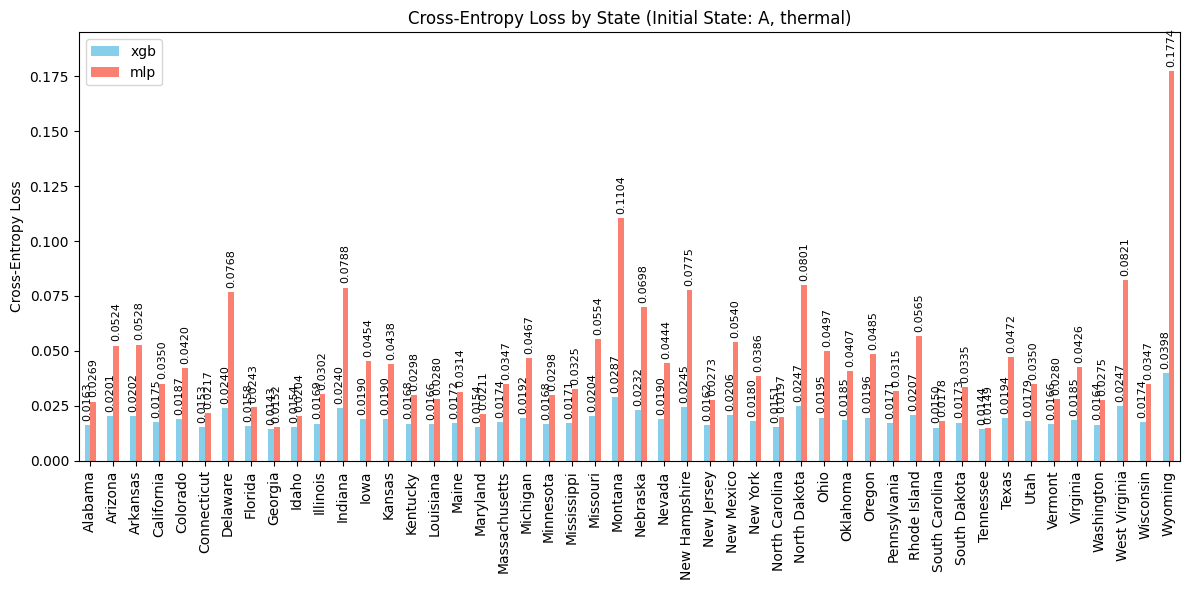

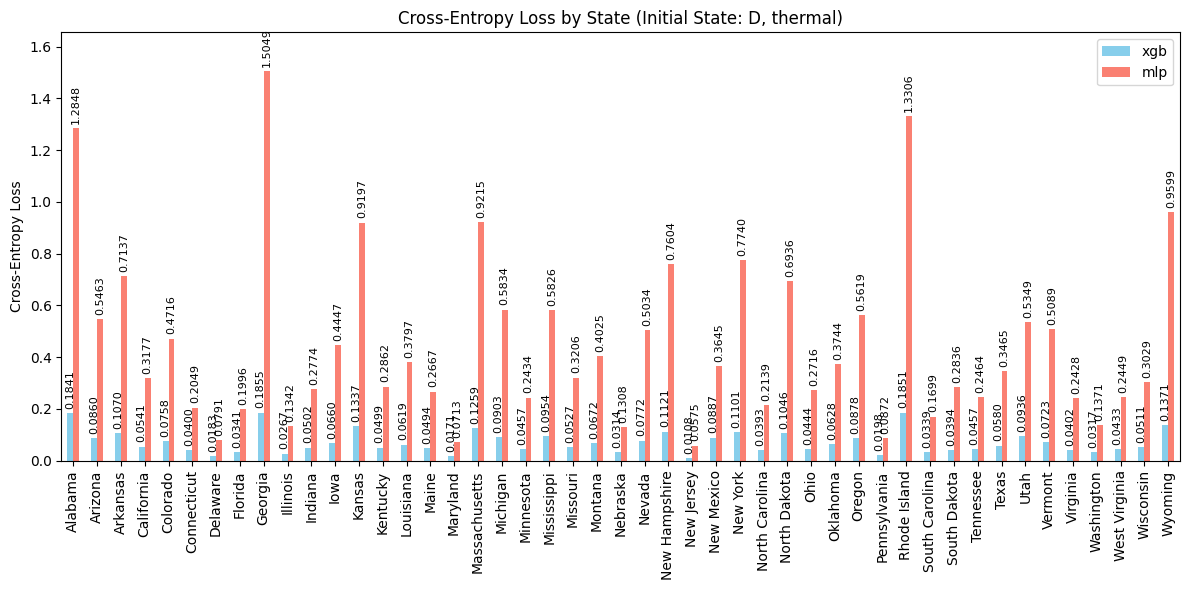

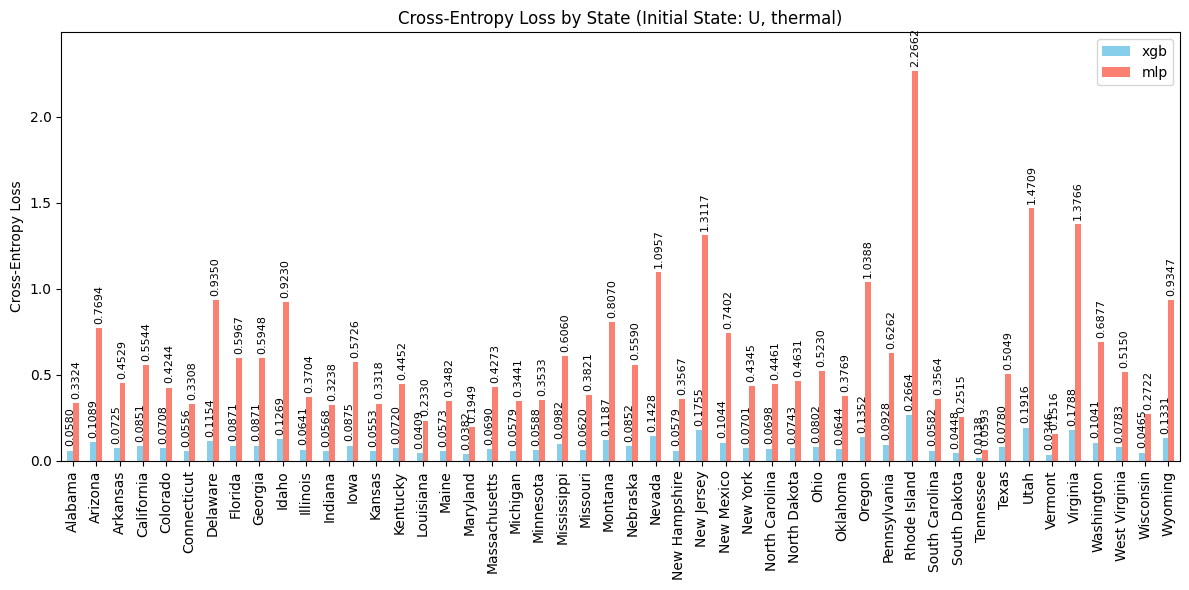

In [11]:
for initial_state in ['A', 'D', 'U']:
    scores_df = scores_per_state[initial_state]
    fig, ax = plt.subplots(figsize=(12, 6))
    scores_df.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
    ax.set_title(f'Cross-Entropy Loss by State (Initial State: {initial_state}, {techno})')
    ax.set_ylabel('Cross-Entropy Loss')
    ax.set_ylim(0, scores_df.values.max() * 1.1)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=8, rotation=90, xytext=(0, 3),
                    textcoords='offset points')
    plt.tight_layout()

### By technology

# Feature importance

In [12]:
m = models['A']['xgb']

/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py:2225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(imp_df['Feature'][:n_features], rotation=45, ha='right', fontsize=20)
/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py:2225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(imp_df['Feature'][:n_features], rotation=45, ha='right', fontsize=20)
/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py:2225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(imp_df['Feature'][:n_features], rotation=45, ha='right', fontsize=20)


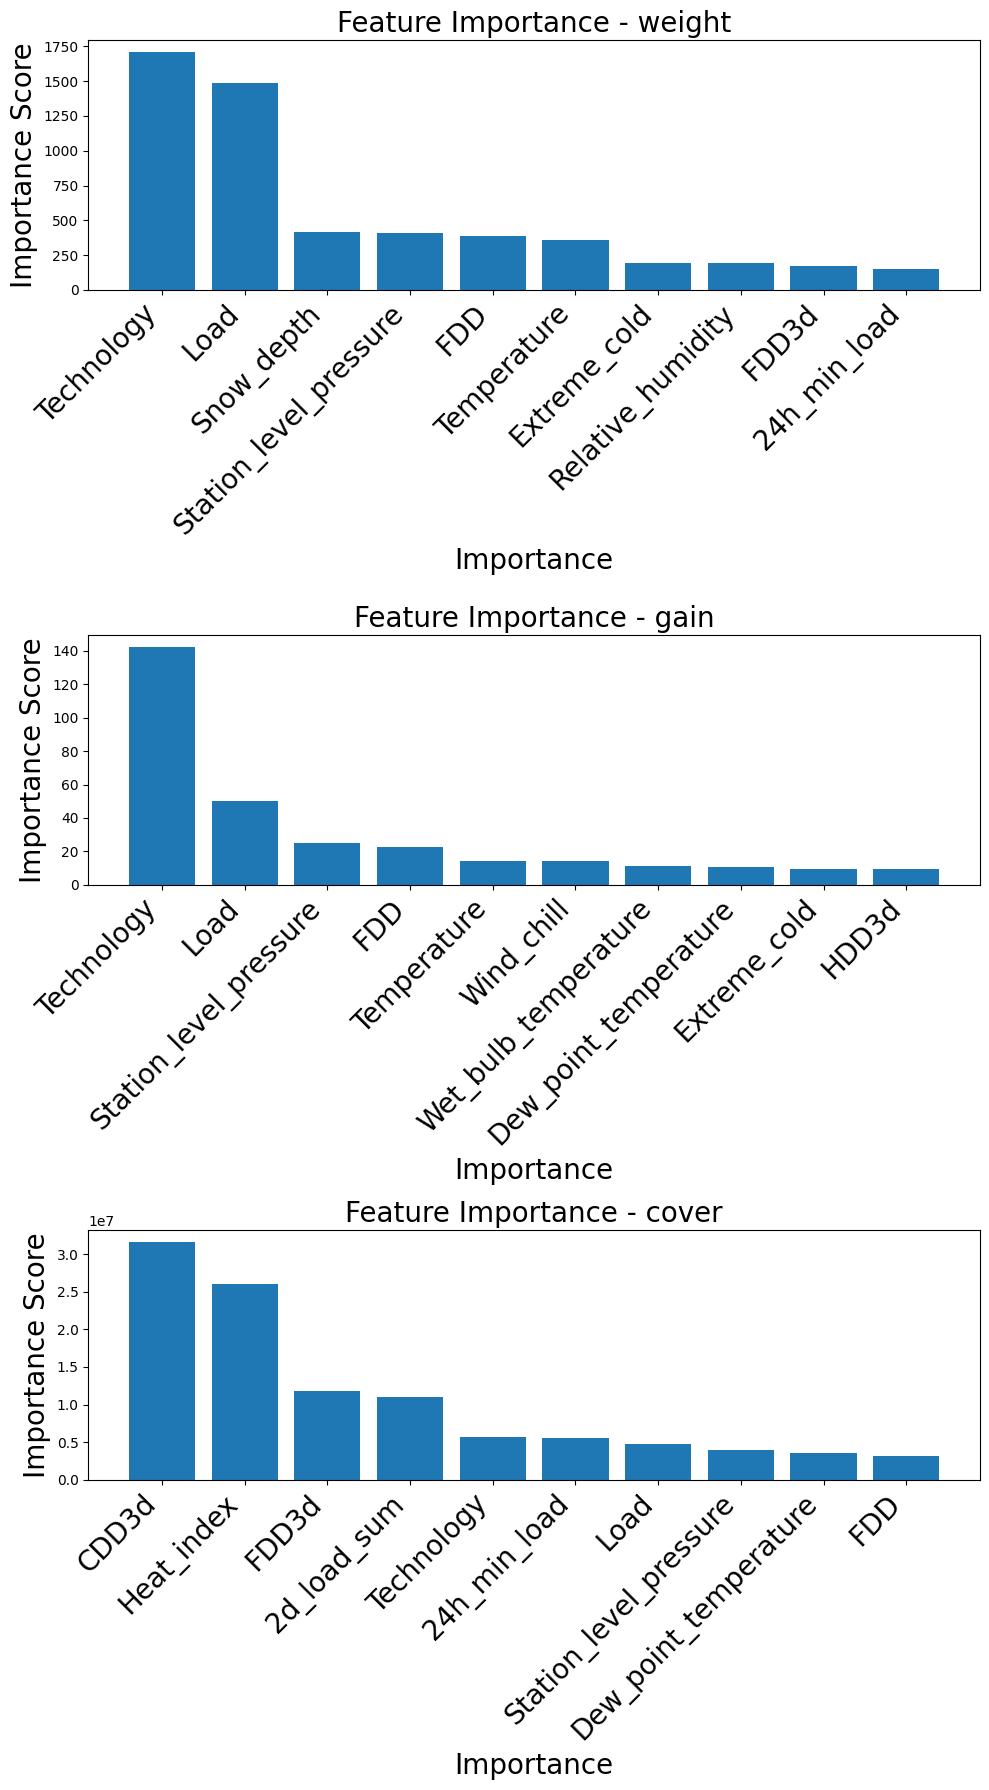

In [13]:
m.plotFeatureImportance()

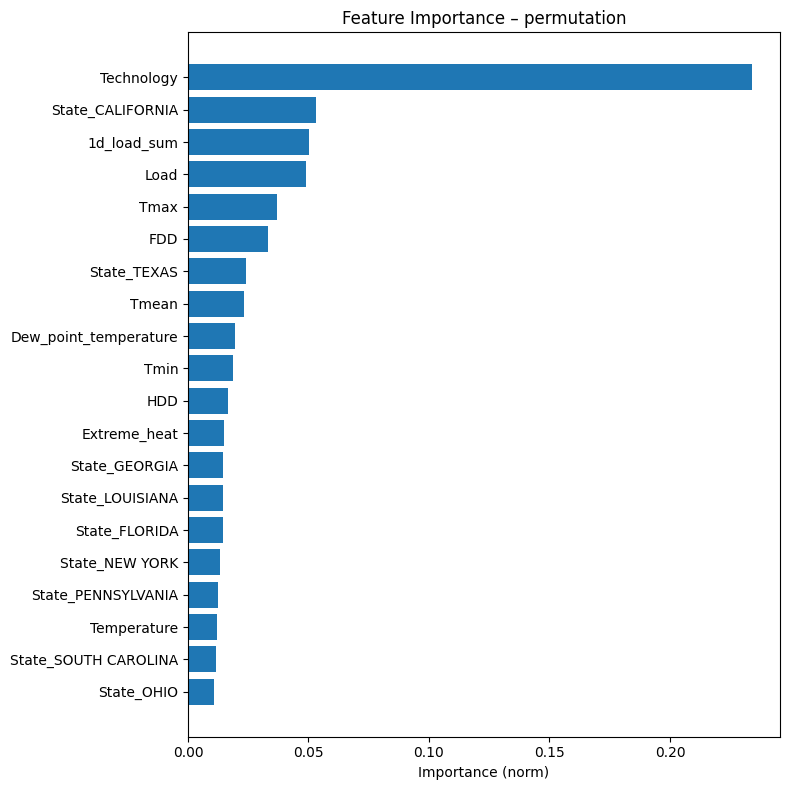

In [14]:
m2 = models['A']['mlp']
m2.prepare_data(test_data['A'], train_ratio=0.8, val_ratio=0.2, standardize=stand_cols)
m2.plot_feature_importance()

# Feature relation visualization

In [49]:
all_data = pd.concat([train_data['A'], train_data['D'], train_data['U'],
                      test_data['A'], test_data['D'], test_data['U']], ignore_index=True)

# all_data = pd.concat([train_data['A'],
#                       test_data['A']], ignore_index=True)

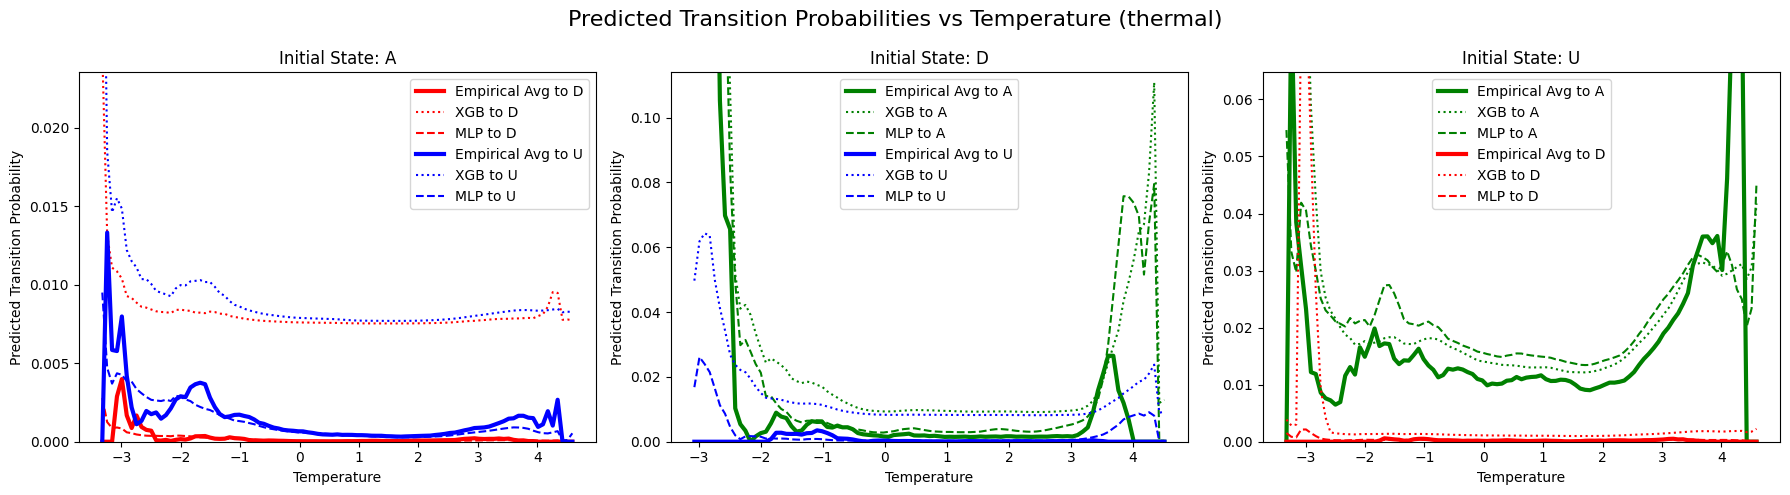

In [48]:
feature = 'Temperature'
colors = {'A': 'green', 'D': 'red', 'U': 'blue'}
if feature not in feature_names:
    raise ValueError(f"Feature '{feature}' not found in feature names.")


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, initial_state in enumerate(['A', 'D', 'U']):
    ax = axs[i]
    feat_min = all_data[feature].min()
    feat_max = all_data[feature].max()
    feat_range = np.linspace(feat_min, feat_max, 100)
    gap_x = feat_range[1]-feat_range[0]
    
    inputs = test_data[initial_state].copy()
    x_vals = test_data[initial_state][feature].values
    weights = inputs['Data_weight'].values
    xgb_features = models[initial_state]['xgb'].feature_cols
    prob_xgb = models[initial_state]['xgb'].predict(inputs[xgb_features])
    mlp_features = models[initial_state]['mlp'].feature_cols
    prob_mlp = models[initial_state]['mlp'].predict(inputs[mlp_features])
    prob_xgb_plot = []
    prob_mlp_plot = []
    for x in feat_range:
        f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
        if sum(weights[f_idx]) == 0:
            prob_xgb_plot.append(np.array([np.nan, np.nan, np.nan]))
            prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
            continue
        prob_xgb_plot.append(np.average(prob_xgb[f_idx], axis=0, weights=weights[f_idx]))
        prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
    prob_xgb = np.array(prob_xgb_plot)
    prob_mlp = np.array(prob_mlp_plot)



    # Compute empirical frequency

    empirical_feq = CE_min(test_data[initial_state], mlp_features)

    avg_probs = []
    for x in feat_range:
        f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        f = empirical_feq[f_idx]
        w = weights[f_idx]
        if sum(w) == 0:
            avg_probs.append(np.array([np.nan, np.nan, np.nan]))
            continue
        avg_prob = np.average(f, axis=0, weights=w)
        # n_interval = np.sum((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        # if n_interval > 0:
        #     avg_prob = np.sum(f, axis=0) / n_interval
        # else:
        #     avg_prob = np.array([np.nan, np.nan, np.nan])
        avg_probs.append(avg_prob)
    


    for j, end_state in enumerate(['A', 'D', 'U']):
        if end_state == initial_state:
            continue

        ax.plot(feat_range, [ap[j] for ap in avg_probs], label=f'Empirical Avg to {end_state}', linestyle='-', linewidth=3, color=colors[end_state])
        ax.plot(feat_range, prob_xgb[:, j], label=f'XGB to {end_state}', linestyle=':', color=colors[end_state])
        ax.plot(feat_range, prob_mlp[:, j], label=f'MLP to {end_state}', linestyle='--', color=colors[end_state])

    ax.set_title(f'Initial State: {initial_state}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Predicted Transition Probability')
    ax.legend()
    vals4axis = np.concatenate([prob_xgb[:, [k for k in range(3) if k != i]].flatten(), prob_mlp[:, [k for k in range(3) if k != i]].flatten()])
    vals4axis = vals4axis[~np.isnan(vals4axis)]
    ax.set_ylim(0, 5 * np.mean(vals4axis))
plt.suptitle(f'Predicted Transition Probabilities vs {feature} ({techno})', fontsize=16)
plt.tight_layout()


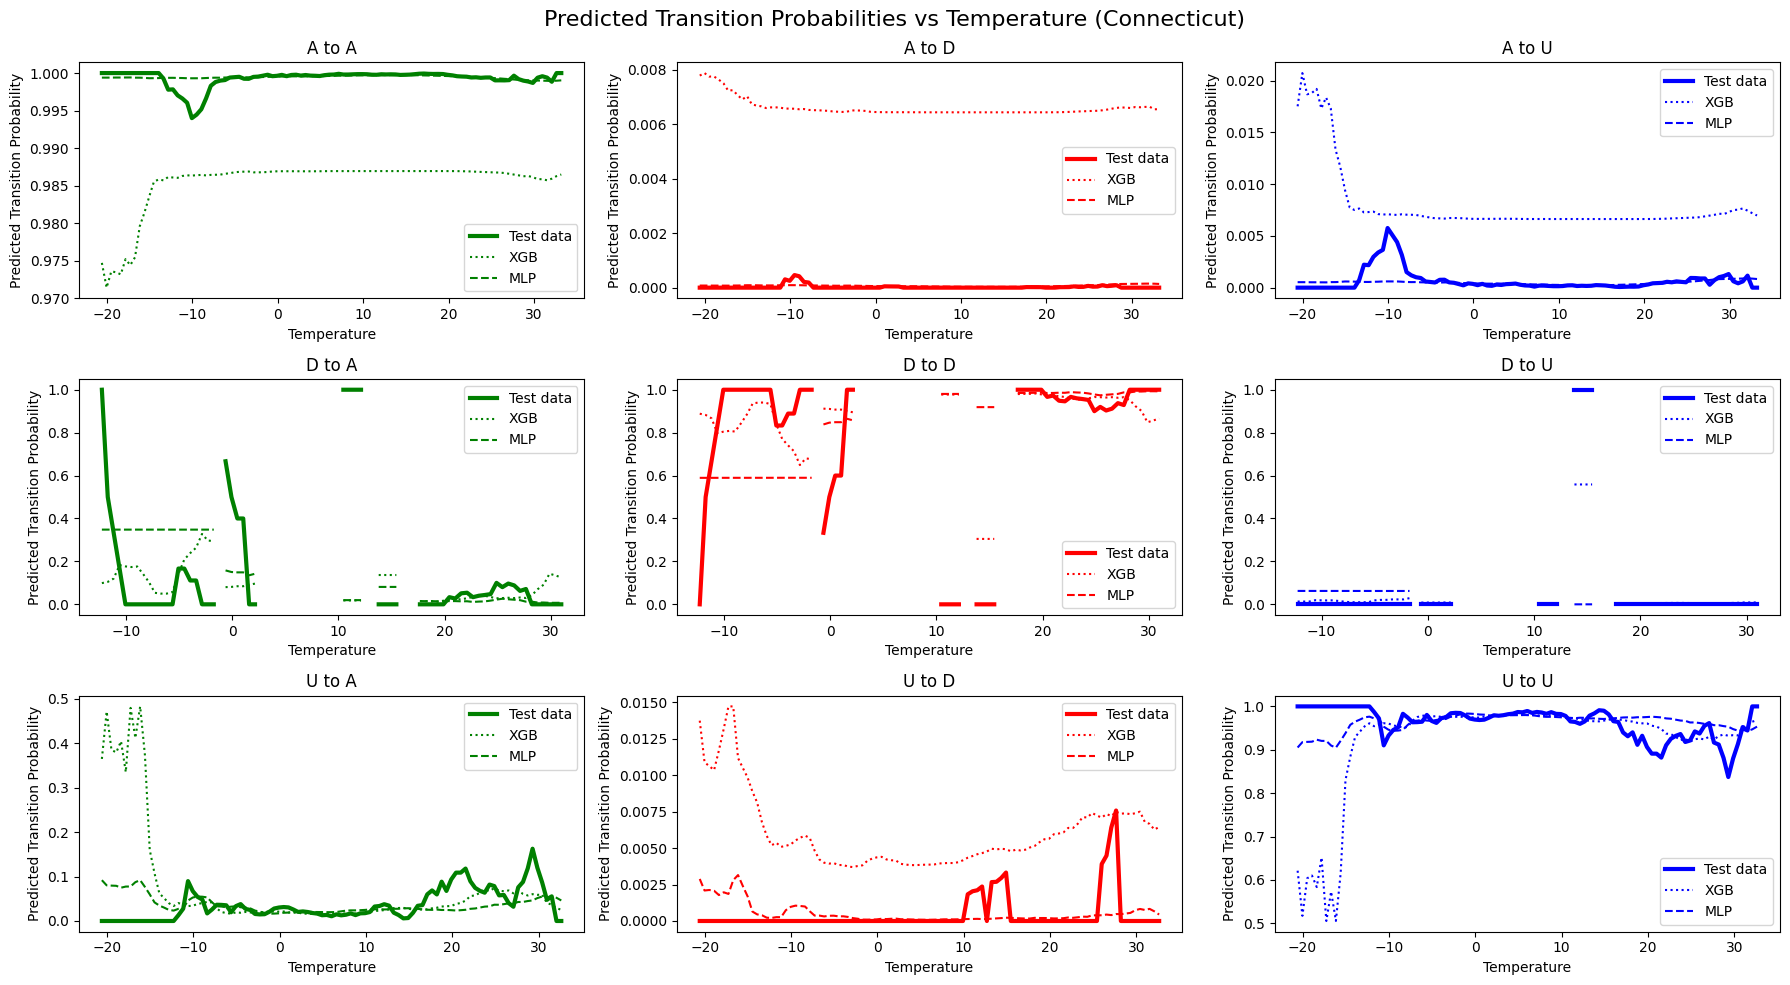

In [64]:
feature = 'Temperature'
state = 'Connecticut'
colors = {'A': 'green', 'D': 'red', 'U': 'blue'}
if feature not in feature_names:
    raise ValueError(f"Feature '{feature}' not found in feature names.")

all_data_plot = all_data.loc[all_data['State_'+state.upper()] == 1].copy()


fig, axs = plt.subplots(3, 3, figsize=(18, 10))
for i, initial_state in enumerate(['A', 'D', 'U']):
    feat_min = all_data_plot[feature].min()
    feat_max = all_data_plot[feature].max()
    feat_range = np.linspace(feat_min, feat_max, 100)
    gap_x = feat_range[1]-feat_range[0]

    test_data_plot = test_data[initial_state].loc[test_data[initial_state]['State_'+state.upper()] == 1].copy()

    inputs = test_data_plot.copy()
    x_vals = test_data_plot[feature].values
    weights = inputs['Data_weight'].values
    xgb_features = models[state][initial_state]['xgb'].feature_cols
    prob_xgb = models[state][initial_state]['xgb'].predict(inputs[xgb_features])
    mlp_features = models[state][initial_state]['mlp'].feature_cols
    prob_mlp = models[state][initial_state]['mlp'].predict(inputs[mlp_features])
    prob_xgb_plot = []
    prob_mlp_plot = []
    for x in feat_range:
        f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
        if sum(weights[f_idx]) == 0:
            prob_xgb_plot.append(np.array([np.nan, np.nan, np.nan]))
            prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
            continue
        prob_xgb_plot.append(np.average(prob_xgb[f_idx], axis=0, weights=weights[f_idx]))
        prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
    prob_xgb = np.array(prob_xgb_plot)
    prob_mlp = np.array(prob_mlp_plot)



    # Compute empirical frequency

    empirical_feq = CE_min(test_data_plot, mlp_features)

    avg_probs = []
    for x in feat_range:
        f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        f = empirical_feq[f_idx]
        w = weights[f_idx]
        if sum(w) == 0:
            avg_probs.append(np.array([np.nan, np.nan, np.nan]))
            continue
        avg_prob = np.average(f, axis=0, weights=w)
        # n_interval = np.sum((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        # if n_interval > 0:
        #     avg_prob = np.sum(f, axis=0) / n_interval
        # else:
        #     avg_prob = np.array([np.nan, np.nan, np.nan])
        avg_probs.append(avg_prob)
    


    for j, end_state in enumerate(['A', 'D', 'U']):
        ax = axs[i, j]

        ax.plot(feat_range*10, [ap[j] for ap in avg_probs], label=f'Test data', linestyle='-', linewidth=3, color=colors[end_state])
        ax.plot(feat_range*10, prob_xgb[:, j], label=f'XGB', linestyle=':', color=colors[end_state])
        ax.plot(feat_range*10, prob_mlp[:, j], label=f'MLP', linestyle='--', color=colors[end_state])

        ax.set_title(f'{initial_state} to {end_state}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Predicted Transition Probability')
        ax.legend()
        vals4axis = np.concatenate([prob_xgb[:, i].flatten(), prob_mlp[:, i].flatten()])
        vals4axis = vals4axis[~np.isnan(vals4axis)]
        # ax.set_ylim(np.min(vals4axis)*0.9, np.max(vals4axis)*1.1)
plt.suptitle(f'Predicted Transition Probabilities vs {feature} ({state})', fontsize=16)
plt.tight_layout()


# Per state model

In [49]:
state = 'California'

In [51]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [53]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']




test_data_state = {}
train_data_state = {}

for initial_state in ['A', 'D', 'U']:
    print(f"\nProcessing initial MC state: {initial_state}")
    # ---------- Merge + label prep ----------
    train_df, test_df, feature_names_state, target_columns_state, integer_encoding_state = im.preprocess_data(failure_data_path=failure_data_file,
                                                                                weather_data_path=weather_data_file,
                                                                                power_load_data_path=power_load_file,
                                                                                feature_names=feature_names_base,
                                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                state_one_hot=True,
                                                                                initial_MC_state_filter=initial_state,
                                                                                technology_filter=technologies,
                                                                                test_periods=test_periods,
                                                                                state_filter=state
                                                                                )
    test_data_state[initial_state] = test_df
    train_data_state[initial_state] = train_df

# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols_state = [f for f in feature_names_state if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols_state)}): {stand_cols_state}")

feature_names_state.sort()
stand_cols_state.sort()
target_columns_state.sort()

print(f"Encoding for 'Final_gen_state': {integer_encoding_state['Final_gen_state']}")

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']

Processing initial MC state: A

Processing initial MC state: D

Processing initial MC state: U
Standardized features (31): ['FDD3d', '24h_min_load', 'Wind_chill', 'Tmean', 'Heat_index', 'Sea_level_pressure', 'Tmax', '2d_load_sum', 'Precipitation', 'FDD', 'Station_level_pressure', 'Snow_depth', 'Wind_speed', 'Load', 'Pressure_3hr_change', 'Dew_point_temperature', 'Extreme_heat', 'Precip_1d', '1d_load_sum', 'Extreme_cold', 'Hourly_load_change', 'T

In [57]:
models_state = defaultdict(dict)

# ---------- Load models ----------
for initial_state in ['A', 'D', 'U']:
    # -- MLP --
    mlp_loader = im.MLP(verbose=False)
    mlp_model = mlp_loader.load_model(f"../Results/Models/MLP_model_{state}_{techno}_{initial_state}.pth")
    models_state[initial_state]['mlp'] = mlp_model

    # -- XGBoost --
    xgb_loader = im.xgboostModel(verbose=False)
    xgb_model = xgb_loader.load_model(f"../Results/Models/XGB_model_{state}_{techno}_{initial_state}.pth")
    models_state[initial_state]['xgb'] = xgb_model

Sequential(
  (linear_0): Linear(in_features=43, out_features=128, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=128, out_features=128, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=64, out_features=32, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=32, out_features=32, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=32, out_features=32, bias=True)
  (activation_5): ReLU()
  (linear_6): Linear(in_features=32, out_features=32, bias=True)
  (activation_6): ReLU()
  (linear_7): Linear(in_features=32, out_features=32, bias=True)
  (activation_7): ReLU()
  (linear_out): Linear(in_features=32, out_features=3, bias=True)
)
Input dim: 43 | Output dim: 3 | Trainable params: 36,803
Loaded MLP from ../Results/Models/MLP_model_California_thermal_A.pth
Rebuilt with build_model(**['feature_cols', 'target_cols', 'num_classe

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [58]:

all_data_state = pd.concat([train_data_state['A'], train_data_state['D'], train_data_state['U'],
                      test_data_state['A'], test_data_state['D'], test_data_state['U']], ignore_index=True)

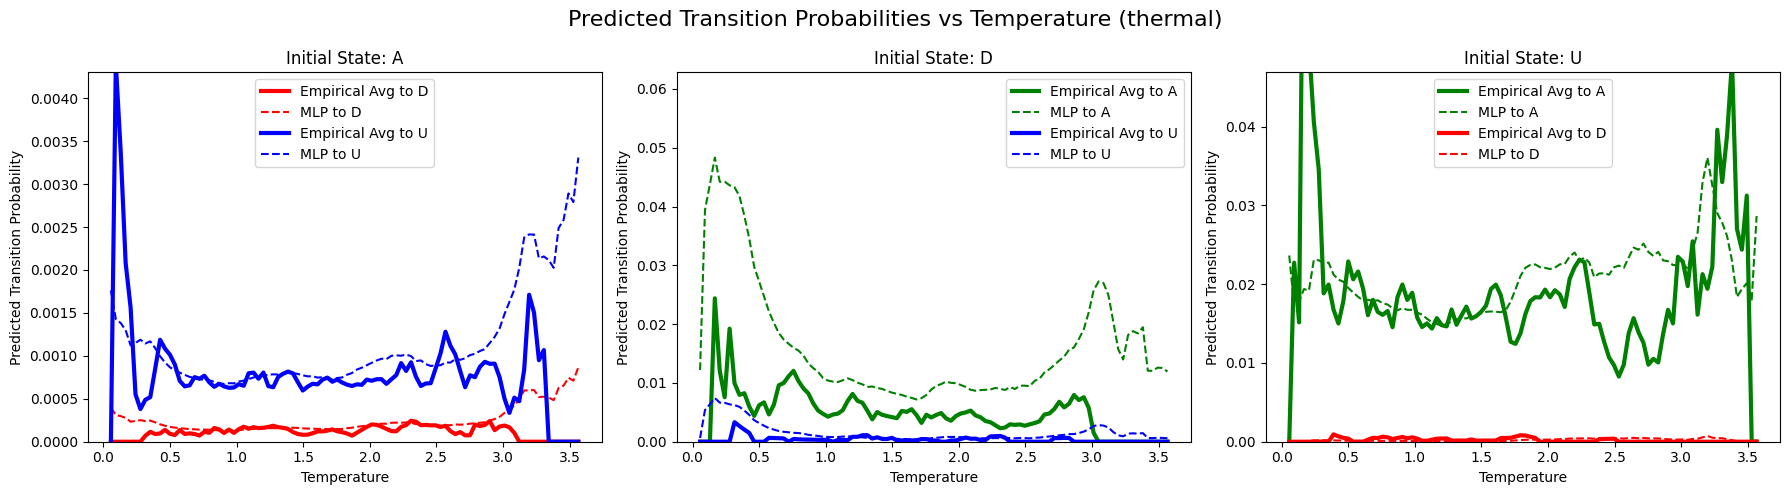

In [62]:
feature = 'Temperature'
colors = {'A': 'green', 'D': 'red', 'U': 'blue'}
if feature not in feature_names_state:
    raise ValueError(f"Feature '{feature}' not found in feature names.")


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, initial_state in enumerate(['A', 'D', 'U']):
    ax = axs[i]
    feat_min = all_data_state[feature].min()
    feat_max = all_data_state[feature].max()
    feat_range = np.linspace(feat_min, feat_max, 100)
    gap_x = feat_range[1]-feat_range[0]
    
    inputs = test_data_state[initial_state].copy()
    x_vals = test_data_state[initial_state][feature].values
    weights = inputs['Data_weight'].values
    xgb_features = models_state[initial_state]['xgb'].feature_cols
    prob_xgb = models_state[initial_state]['xgb'].predict(inputs[xgb_features])
    mlp_features = models_state[initial_state]['mlp'].feature_cols
    prob_mlp = models_state[initial_state]['mlp'].predict(inputs[mlp_features])
    prob_xgb_plot = []
    prob_mlp_plot = []
    for x in feat_range:
        f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
        if sum(weights[f_idx]) == 0:
            prob_xgb_plot.append(np.array([np.nan, np.nan, np.nan]))
            prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
            continue
        prob_xgb_plot.append(np.average(prob_xgb[f_idx], axis=0, weights=weights[f_idx]))
        prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
    prob_xgb = np.array(prob_xgb_plot)
    prob_mlp = np.array(prob_mlp_plot)



    # Compute empirical frequency

    empirical_feq = CE_min(test_data_state[initial_state], mlp_features)

    avg_probs = []
    for x in feat_range:
        f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        f = empirical_feq[f_idx]
        w = weights[f_idx]
        if sum(w) == 0:
            avg_probs.append(np.array([np.nan, np.nan, np.nan]))
            continue
        avg_prob = np.average(f, axis=0, weights=w)
        # n_interval = np.sum((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        # if n_interval > 0:
        #     avg_prob = np.sum(f, axis=0) / n_interval
        # else:
        #     avg_prob = np.array([np.nan, np.nan, np.nan])
        avg_probs.append(avg_prob)
    


    for j, end_state in enumerate(['A', 'D', 'U']):
        if end_state == initial_state:
            continue

        ax.plot(feat_range, [ap[j] for ap in avg_probs], label=f'Empirical Avg to {end_state}', linestyle='-', linewidth=3, color=colors[end_state])
        # ax.plot(feat_range, prob_xgb[:, j], label=f'XGB to {end_state}', linestyle=':', color=colors[end_state])
        ax.plot(feat_range, prob_mlp[:, j], label=f'MLP to {end_state}', linestyle='--', color=colors[end_state])

    ax.set_title(f'Initial State: {initial_state}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Predicted Transition Probability')
    ax.legend()
    vals4axis = np.concatenate([prob_xgb[:, [k for k in range(3) if k != i]].flatten(), prob_mlp[:, [k for k in range(3) if k != i]].flatten()])
    vals4axis = prob_mlp[:, [k for k in range(3) if k != i]].flatten()
    vals4axis = vals4axis[~np.isnan(vals4axis)]
    ax.set_ylim(0, 1.3 * np.max(vals4axis))
plt.suptitle(f'Predicted Transition Probabilities vs {feature} ({techno})', fontsize=16)
plt.tight_layout()


# Covariate reweighting comparison

In [76]:
all_data = pd.concat([train_data['A'], train_data['D'], train_data['U'],
                      test_data['A'], test_data['D'], test_data['U']], ignore_index=True)

In [135]:
models_reweighting = defaultdict(lambda: defaultdict(dict))

for w in ['', '_no_all']:
    for initial_state in ['A']:#, 'D', 'U']:
        
        # -- MLP --
        # try:
        mlp_loader = im.MLP(verbose=False)
        mlp_model = mlp_loader.load_model(f"../Results/Models/MLP_model{w}_{techno}_{initial_state}.pth")
        models_reweighting[w][initial_state]['mlp'] = mlp_model
        # except Exception as e:
        #     print(f"Could not load MLP model for state {state} and initial state {initial_state}: {e}")
        #     pass


Sequential(
  (linear_0): Linear(in_features=90, out_features=256, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=256, out_features=512, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=256, out_features=128, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=128, out_features=64, bias=True)
  (activation_4): ReLU()
  (linear_out): Linear(in_features=64, out_features=3, bias=True)
)
Input dim: 90 | Output dim: 3 | Trainable params: 327,555
Loaded MLP from ../Results/Models/MLP_model_thermal_A.pth
Rebuilt with build_model(**['feature_cols', 'target_cols', 'num_classes', 'hidden_sizes', 'activations', 'out_act_fn'])
Sequential(
  (linear_0): Linear(in_features=90, out_features=256, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=256, out_features=512, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_feature

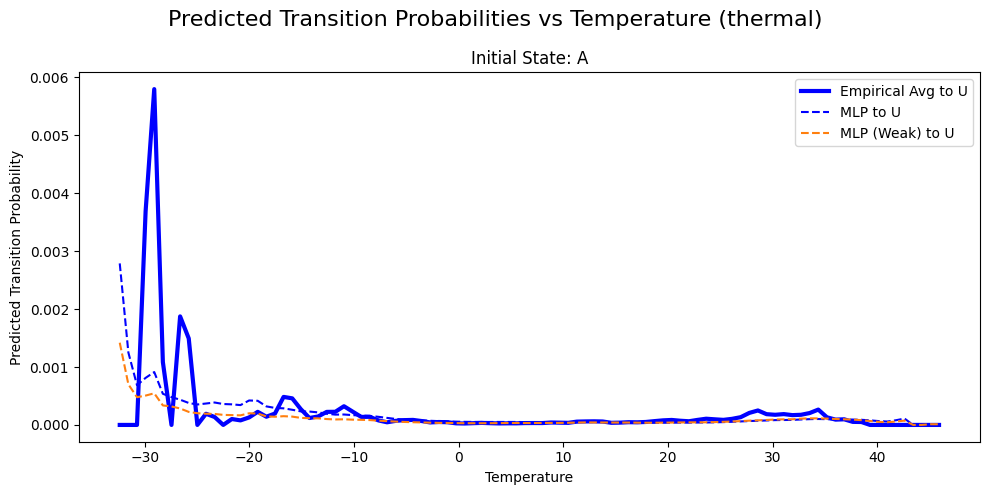

In [161]:
feature = 'Temperature'
colors = {'A': 'green', 'D': 'red', 'U': 'blue'}
if feature not in feature_names:
    raise ValueError(f"Feature '{feature}' not found in feature names.")


fig, ax = plt.subplots(figsize=(10, 5))
feat_min = all_data[feature].min()
feat_max = all_data[feature].max()
feat_range = np.linspace(feat_min, feat_max, 100)
gap_x = (feat_range[1]-feat_range[0])

inputs = test_data[initial_state].copy()
x_vals = test_data[initial_state][feature].values
weights = inputs['Data_weight'].values

mlp_model = models_reweighting[''][initial_state]['mlp']
mlp_features = mlp_model.feature_cols
prob_mlp = mlp_model.predict(inputs[mlp_features])

mlp_model_weak = models_reweighting['_no_all'][initial_state]['mlp']
mlp_features_weak = mlp_model_weak.feature_cols
prob_mlp_weak = mlp_model_weak.predict(inputs[mlp_features_weak])
prob_mlp_plot = []
prob_mlp_weak_plot = []
for x in feat_range:
    f_idx = np.where((inputs[feature] >= x - gap_x) & (inputs[feature] < x + gap_x))
    if sum(weights[f_idx]) == 0:
        prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
        prob_mlp_weak_plot.append(np.array([np.nan, np.nan, np.nan]))
        continue
    prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
    prob_mlp_weak_plot.append(np.average(prob_mlp_weak[f_idx], axis=0, weights=weights[f_idx]))
prob_mlp = np.array(prob_mlp_plot)
prob_mlp_weak = np.array(prob_mlp_weak_plot)



# Compute empirical frequency

empirical_feq = CE_min(test_data['A'], mlp_features)

avg_probs = []
for x in feat_range:
    f_idx = np.where((x_vals >= x - gap_x) & (x_vals < x + gap_x))
    f = empirical_feq[f_idx]
    w = weights[f_idx]
    if sum(w) == 0:
        avg_probs.append(np.array([np.nan, np.nan, np.nan]))
        continue
    avg_prob = np.average(f, axis=0, weights=w)
    # n_interval = np.sum((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
    # if n_interval > 0:
    #     avg_prob = np.sum(f, axis=0) / n_interval
    # else:
    #     avg_prob = np.array([np.nan, np.nan, np.nan])
    avg_probs.append(avg_prob)




j = 1
ax.plot(feat_range*10, [ap[j] for ap in avg_probs], label=f'Empirical Avg to {end_state}', linestyle='-', linewidth=3, color=colors[end_state])
ax.plot(feat_range*10, prob_mlp[:, j], label=f'MLP to {end_state}', linestyle='--', color=colors[end_state])
ax.plot(feat_range*10, prob_mlp_weak[:, j], label=f'MLP (Weak) to {end_state}', linestyle='--', color='tab:orange')

ax.set_title(f'Initial State: {initial_state}')
ax.set_xlabel(feature)
ax.set_ylabel('Predicted Transition Probability')
ax.legend()
vals4axis = prob_mlp[:, j].flatten()
vals4axis = vals4axis[~np.isnan(vals4axis)]
# ax.set_ylim(0, 1.3 * np.max(vals4axis))
plt.suptitle(f'Predicted Transition Probabilities vs {feature} ({techno})', fontsize=16)
plt.tight_layout()


In [132]:
(prob_mlp==prob_mlp_weak).mean()

np.float64(0.97)

# Feature importance

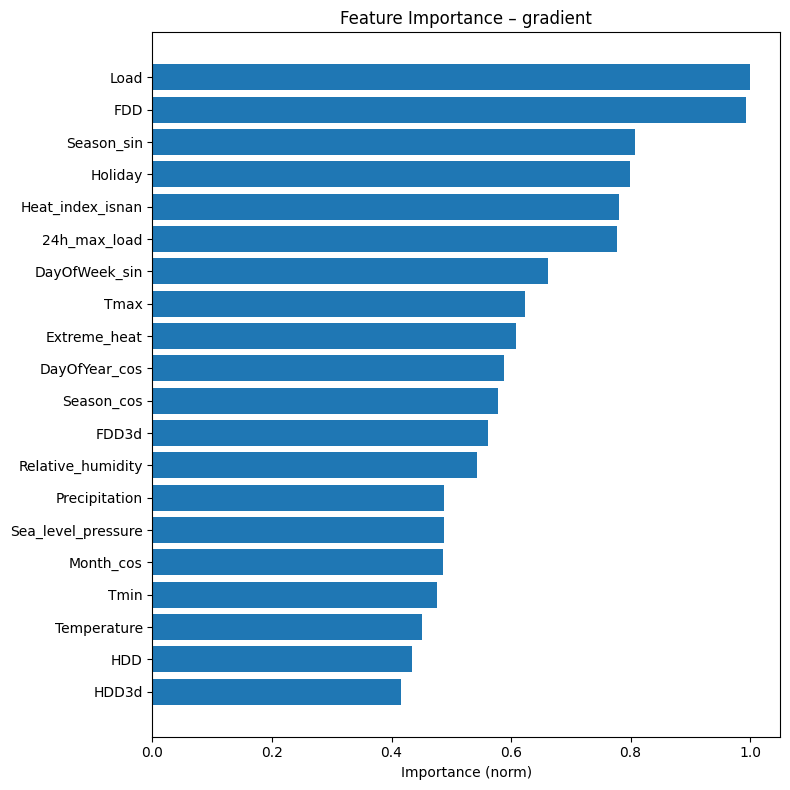

In [160]:
s = 'Connecticut'

mA = models[s]['U']['mlp']
mA.prepare_data(all_data.loc[all_data['State_'+s.upper()]==1], train_ratio=0.8, val_ratio=0.2, standardize=stand_cols)
mA.plot_feature_importance(method='gradient')

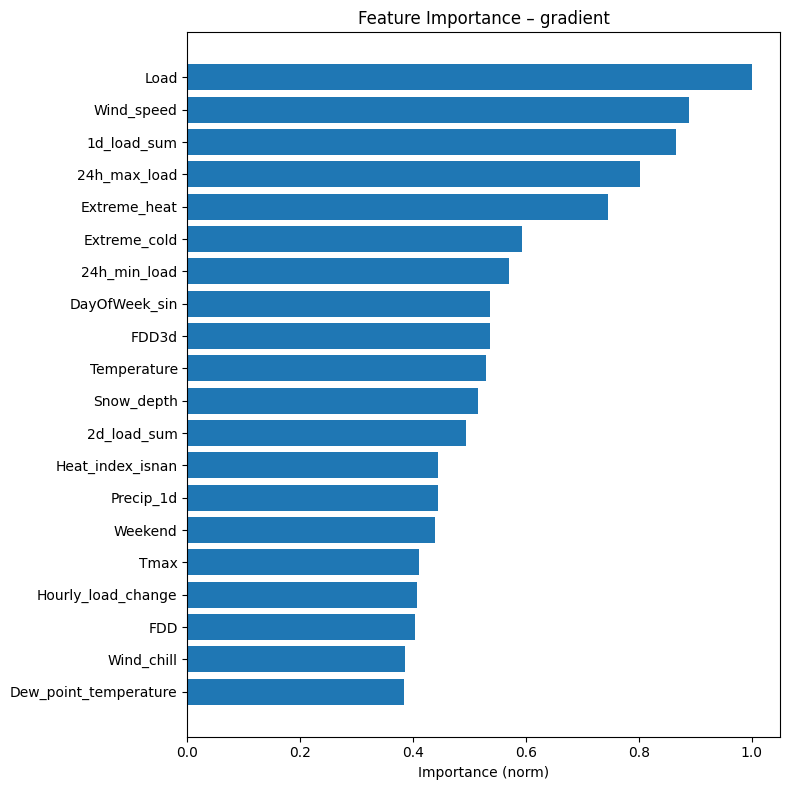

In [143]:
mA = models['Connecticut']['A']['mlp']
mA.prepare_data(all_data, train_ratio=0.8, val_ratio=0.2, standardize=stand_cols)
mA.plot_feature_importance(method='gradient')

In [ ]:
mA = models['Global']['A']['mlp']
mA.prepare_data(all_data, train_ratio=0.8, val_ratio=0.2, standardize=stand_cols)
mA.plot_feature_importance(method='gradient')

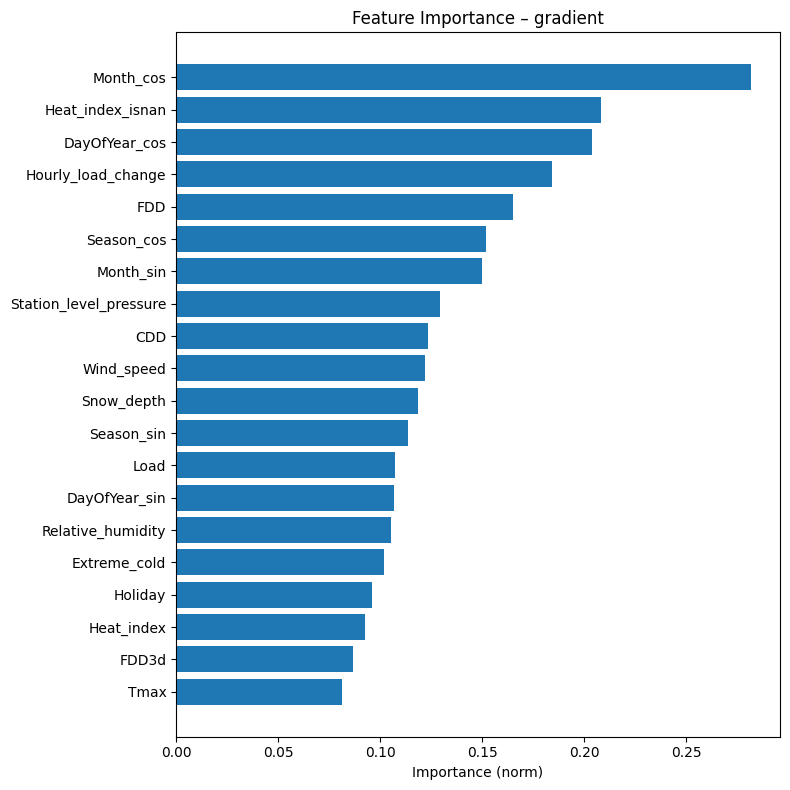

In [118]:
mA.plot_feature_importance(method='gradient')

In [123]:
mD = models['Global']['D']['mlp']
mD.prepare_data(all_data, train_ratio=0.8, val_ratio=0.2, standardize=stand_cols)

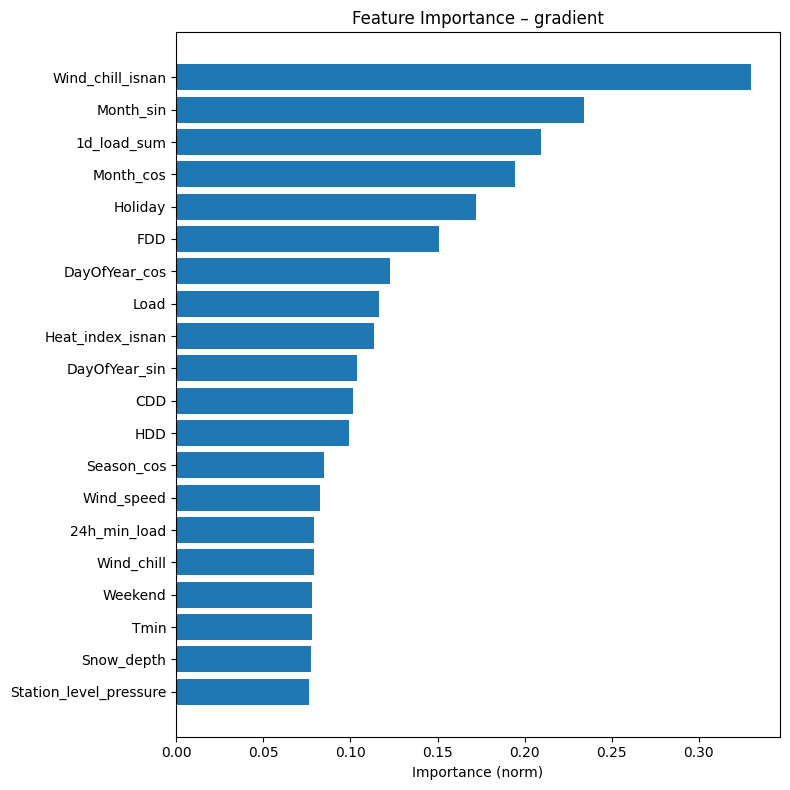

In [124]:
mD.plot_feature_importance(method='gradient')

In [125]:
mU = models['Global']['U']['mlp']
mU.prepare_data(all_data, train_ratio=0.8, val_ratio=0.2, standardize=stand_cols)

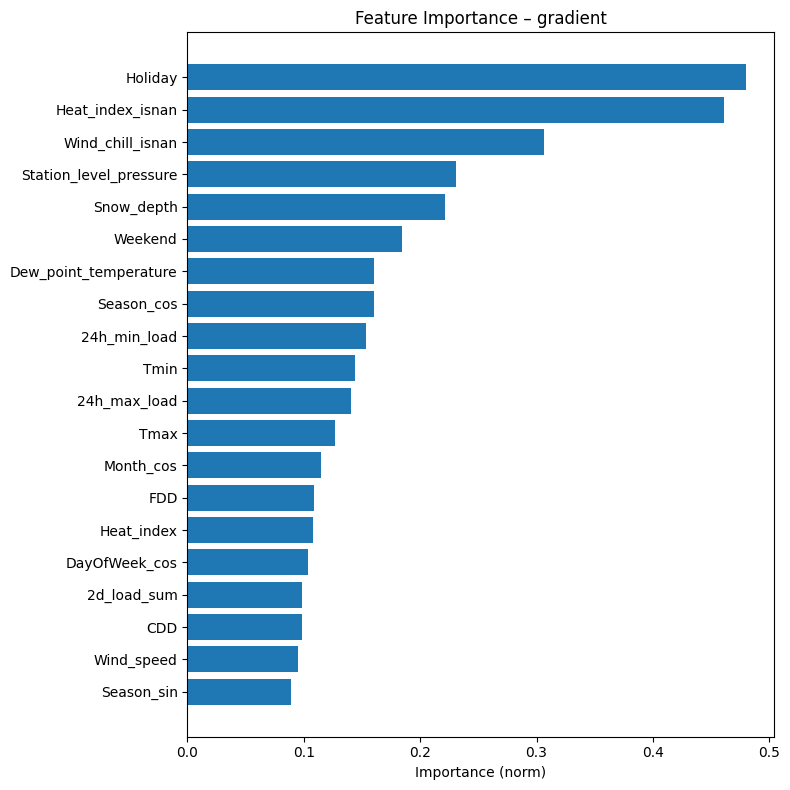

In [126]:
mU.plot_feature_importance(method='gradient')